Analysis of the different cells - 09.07.2023

copy made: 04.09.2023 (after already changing much)

In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
from tqdm.notebook import tqdm

from napari import view_image
import matplotlib.pyplot as plt
import seaborn

from read_files import read_files_pipeline, from_files_to_df, read_cizlif_file

In [2]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import matplotlib.patches as mpatches

import skimage
from skimage.filters import threshold_otsu
from skimage.morphology import area_closing, disk, binary_closing, remove_small_holes
from skimage.measure import label, regionprops
from skimage.io import imsave
from itertools import product
from skimage.morphology import convex_hull_image

from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage as ndi

from skimage.morphology import convex_hull_image
import skimage
import skimage.io as skio

from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
from skimage import data
from skimage import transform
from skimage.feature import (match_descriptors, corner_harris,
                             corner_peaks, ORB, plot_matches)
from skimage import segmentation
from skimage.segmentation import expand_labels
from skimage import filters
from skimage import morphology
from skimage import measure
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

import cv2 as cv
import cv2

In [3]:
root = Path('data', 'segmented')
data_path = Path('.', 'data')
plot_path = Path('.', 'plots')

# Function definitions

Function definitions for doing the segementation

In [ ]:
def pipe_get_first_labels(df_select):
    nuclei, info = read_cizlif_file(df_select['filepath'],
                                    df_select['id_scene'],
                                    date=df_select['date'])

    # check if everything is the same
    for info_i in info:
        if isinstance(info[info_i], (int, float)):
            # print(np.abs(info[info_i] - df_select[info_i]), info[info_i], df_select[info_i])
            if np.abs(info[info_i] - df_select[info_i]) > 1e-7:
                print('Information loaded and saved is different!')
                print(f'info_i, {info[info_i]} vs {df_select[info_i]}')
                print(f'{df_select["filename"]}; {df_select["id_file"]}')
            
            df_select[info_i] = info[info_i]
            
        else:
            assert info[info_i] == df_select[info_i]

    if df_select['manual_labeled']:
        print('Already labeled!')

    spacing = np.asarray(df_select[['pixel_size_z',
                                    'pixel_size_x',
                                    'pixel_size_y']].values, dtype=np.float32)

    viewer = view_image(nuclei,
                        # contrast_limits=[0, 1],
                        scale=spacing,
                        ndisplay=3,
                    )
    edges = filters.scharr(nuclei)

    nuclei_layer = viewer.layers['nuclei']
    nuclei_layer.blending = 'additive'
    nuclei_layer.colormap = 'green'

    viewer.add_image(
        edges,
        scale=spacing,
        blending='additive',
        colormap='magenta',
    )
    viewer.layers['edges'].visible = False

    denoised = ndi.median_filter(nuclei, size=3)
    li_thresholded = denoised > filters.threshold_li(denoised)
    viewer.add_image(
        li_thresholded,
        scale=spacing,
        opacity=0.3,
    )

    width = 20

    remove_holes = morphology.remove_small_holes(
        li_thresholded, width ** 3
    )

    width = 20

    remove_objects = morphology.remove_small_objects(
        remove_holes, width ** 3
    )

    viewer.add_image(
        remove_objects,
        name='cleaned',
        scale=spacing,
        opacity=0.3,
    );

    viewer.layers['li_thresholded'].visible = False

    labels = measure.label(remove_objects)

    viewer.add_labels(
        labels,
        scale=spacing,
        opacity=0.5,
    )

    viewer.layers['cleaned'].visible = False

    transformed = ndi.distance_transform_edt(remove_objects, sampling=spacing)

    maxima = morphology.local_maxima(transformed)
    viewer.add_points(
        np.transpose(np.nonzero(maxima)),
        name='bad points',
        scale=spacing,
        size=4,
        n_dimensional=True,  # points have 3D "extent"
    )

    viewer.layers['bad points'].visible = False
    viewer.dims.ndisplay = 2
    viewer.dims.set_point(0, 30 * spacing[0])

    points = viewer.add_points(
        name='interactive points',
        scale=spacing,
        ndim=3,        size=4,
        n_dimensional=True,
    )

    points.mode = 'add'

    print(list(np.unique(labels)))

    return(viewer, points, nuclei, edges, remove_objects, spacing)

def pipe_get_watershed(viewer, points, df_select,
                       nuclei, edges, remove_objects,
                       spacing):
    ## Do watershed
    marker_locations = points.data

    markers = np.zeros(nuclei.shape, dtype=np.uint32)
    marker_indices = tuple(np.round(marker_locations).astype(int).T)
    markers[marker_indices] = np.arange(len(marker_locations)) + 1
    markers_big = morphology.dilation(markers, morphology.ball(5))

    segmented = segmentation.watershed(
        edges,
        markers_big,
        mask=remove_objects,
    )

    viewer.add_labels(
        segmented,
        scale=spacing,
    )

    expanded = expand_labels(segmented, distance=10)

    expanded_copy = np.copy(expanded)
    viewer.add_labels(
        expanded,
        scale=spacing,
        name='expanded labels'

    )

    viewer.layers['labels'].visible = False
    viewer.layers['segmented'].visible = False
    viewer.layers['interactive points'].visible = False

    points_remove = viewer.add_points(
        name='deselect_regions',
        scale=spacing,
        ndim=3,
        size=4,
        n_dimensional=True,
    )
    points_remove.mode = 'add'

    expanded_new = np.copy(expanded)

    print(np.unique(expanded_new))
    ## second

    return(viewer, expanded, nuclei, points_remove)

def pipe_remove_markers(expanded, nuclei, points_remove):
    marker_locations = points_remove.data

    marker_indices = tuple(np.round(marker_locations).astype(int).T)

    expanded_new = np.copy(expanded)
    for val in np.unique(expanded_new[marker_indices]):
        expanded_new[expanded_new == val] = 0

    print(np.unique(expanded_new))
    return (nuclei, expanded_new)


def limit_to_inside_border(expanded, nuclei, points_border):
    marker_locations = points_border.data
    marker_indices = tuple(np.round(marker_locations).astype(int).T)
    


def pipe_plot_marked_regions(df_select, nuclei, expanded_new, root, bad_one=False):
    path = Path('..', root)

    fn_base = df_select[['comparison', 'class', 'type',
                        'cell', 'microscope',
                        'id_file', 'id_scene_count', 'filename']]
    # fn_base = f'{fn_base['filename']}_idscene-{int(fn_base['id_scene_count'])}'
    if isinstance(bad_one, str):
        fn_base = (f"{fn_base['cell']}_{fn_base['class']}_{fn_base['type']}"
            + f"_{fn_base['microscope']}_{fn_base['comparison']}"
            + f"_idfile-{fn_base['id_file']}_idscene-{int(fn_base['id_scene_count'])}_{bad_one}")
    elif not bad_one:
        fn_base = (f"{fn_base['cell']}_{fn_base['class']}_{fn_base['type']}"
                + f"_{fn_base['microscope']}_{fn_base['comparison']}"
                + f"_idfile-{fn_base['id_file']}_idscene-{int(fn_base['id_scene_count'])}")
    else:
        fn_base = (f"{fn_base['cell']}_{fn_base['class']}_{fn_base['type']}"
                + f"_{fn_base['microscope']}_{fn_base['comparison']}"
                + f"_idfile-{fn_base['id_file']}_idscene-{int(fn_base['id_scene_count'])}_bad")

    # plot image
    fig, ax = plt.subplots(1, 3, dpi=200, figsize=(10, 4))
    ax[0].imshow(np.max(expanded_new, axis=0), cmap='tab10', alpha=0.5)
    ax[1].imshow(np.max(nuclei, axis=0))

    ax[2].imshow(np.max(nuclei, axis=0), cmap='Reds')
    ax[2].imshow(np.max(expanded_new, axis=0), cmap='tab10', alpha=0.8)

    for i in range(3):
        ax[i].axis('off')
    ax[0].set_title('labels')
    ax[1].set_title('max-aggregate')
    ax[2].set_title('labels as overlay')

    fig.suptitle(fn_base)
    fig.tight_layout()
    fig.savefig(Path(path, fn_base + '.png'), dpi=200)

    # save the nuclei separately
    bounding_boxes = []
    nuclei_select = {}
    for nuc_count, region in enumerate(regionprops(expanded_new)):
        bbox = region.bbox

        region_select = \
            expanded_new[bbox[0]: bbox[3],
                        bbox[1]: bbox[4],
                        bbox[2]: bbox[5]]
        bounding_boxes.append([bbox[0], bbox[3], bbox[1], bbox[4], bbox[2], bbox[5]])

        image_select = \
            np.copy(nuclei[bbox[0]: bbox[3],
                    bbox[1]: bbox[4],
                    bbox[2]: bbox[5]])
        image_select[region_select != region.label] = np.min(image_select)
        print(np.min(image_select))
        nuclei_select[f'{nuc_count:02d}'] = image_select
    nuclei_select['bounding_boxes'] = np.array(bounding_boxes, dtype=np.int32)

    np.savez_compressed(Path(path, fn_base +'.npz'),
                        **nuclei_select)
    # np.savez_compressed(Path(path, fn_base +'_mask.npz'),
    #                     **nuclei_select)

    df_files.loc[(df_files['id_file'] == df_select['id_file'])
                & (df_files['id_scene'] == df_select['id_scene']),
                'manual_labeled'] = True
    df_files.to_csv(Path('..', root, 'df_files.csv'), index=False)

# Segmentation

In [17]:
# Read files and stop warning from napari to appear
df_files = pd.read_csv(Path(data_path, 'df_files.csv'))
df_files.head()

import warnings
warnings.filterwarnings('ignore')

In [18]:
df_files.loc[(df_files['manual_labeled'] == False)
             & (df_files['comparison'] =='all')].groupby(['microscope', 'cell', 'type'])['comparison'].count()

microscope  cell  type
Airyscan    ES    WT      41
            NS    WT      50
Name: comparison, dtype: int64

## From here on out we need to execute the different cells in a loop again and again after each other. 

This is done, since we are changing the segmentation in the napari window at each step.

1) cell: load the next file which not yet has been labelled
2) do a pre-segmentation using a watershed algorithm
3) pick new starting points for the watershed algorithm, (we can overcluster - see 4/5)
4) If we did overcluster, we can now define border points, which result in all the cluster in this border region to be grouped together.
   1) DO NOT EXECUTE IF YOU DON'T WANT TO SPECIFY THE BORDERS
   2) THIS BORDERS EXTEND TO ALL THE Z-SLICES AT THE SAME TIME; HENCE, IT DOES NOT WORK FOR MOVING CELL BORDERS


In [22]:
# 1) cell: load the next file which not yet has been labelled

i = 0

print('Left:', len(df_files.loc[(df_files['manual_labeled'] == False)
                              & (df_files['microscope'] =='Airyscan')
                              & (df_files['comparison'] =='all')]))
    
idx = df_files.loc[(df_files['manual_labeled'] == False)
                   & (df_files['microscope'] =='Airyscan')
                   & (df_files['comparison'] =='all')].index[i]

df_select = df_files.loc[idx]

print(idx, df_select['cell'], df_select['type'], df_select['microscope'])

if df_select['manual_labeled']:
    print('Already labeled!')

viewer, points, nuclei, edges, remove_objects, spacing = \
    pipe_get_first_labels(df_select)

Left: 91
0 ES WT Airyscan
[0, 1]


In [24]:
# 2) do a pre-segmentation using a watershed algorithm

# repeat above, if we need do the initial segmentation again
viewer, points, nuclei, edges, remove_objects, spacing = \
    pipe_get_first_labels(df_select)

[0, 1]


Now mark the regions (do overclustering to help with separation); click on lower values

In [25]:
# 3) pick new starting points for the watershed algorithm, (we can overcluster - see 4/5)

viewer, expanded, nuclei, points_remove = \
    pipe_get_watershed(viewer, points, df_select,
                       nuclei, edges, remove_objects,
                       spacing)

[ 0  1  2  3  4  5  6  7  8  9 10]


In [252]:
## use if there is not a proper separation and the nuclei do not move too much

marker_locations = points_remove.data
marker_indices = tuple(np.round(marker_locations).astype(int).T)
polygons = [np.asarray([[k, marker_indices[1][i], marker_indices[2][i]]            
                       for i in range(len(marker_indices[0]))])
            for k in range(0, np.shape(nuclei)[0])]
   
shapes_layer = viewer.add_shapes(polygons, shape_type='polygon', name='sliced',
                                 scale=spacing, edge_width=5,
                                 edge_color='coral', face_color='royalblue')
shapes_layer.editable = True
# IN 3D the layers are not editable!
# As note in the section on 3D rendering, when using 3D rendering the shapes layer is not editable.

In [253]:
# execute if exceuting the directly above

labels_mask = shapes_layer.to_labels(np.shape(nuclei))
# first make all labels into 1
labels_mask[(labels_mask > 0)] = 1
# now delete all labels where expanded is 0
labels_mask[expanded == 0] = 0
# now make all labels inside the label_mask the same
expanded[labels_mask > 0] = np.max(expanded) + 1

viewer.layers['sliced'].visible = False

points_remove = viewer.add_points(
        name='deselect_regions',
        scale=spacing,
        ndim=3,
        size=4,
        n_dimensional=True,
    )
points_remove.mode = 'add'

In [26]:
# Now delete the overseparated ones

nuclei, expanded_new = pipe_remove_markers(expanded, nuclei, points_remove)
# pipe_plot_marked_regions(df_select, nuclei, expanded_new)

[0 1 2 3 4]


In [11]:
# check again
view_image(expanded_new)

Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 135.5, 135.5), zoom=2.2597426470588236, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(25.0, 1.0, 0.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=3, ndisplay=2, last_used=0, range=((0.0, 51.0, 1.0), (0.0, 272.0, 1.0), (0.0, 272.0, 1.0)), current_step=(25, 136, 136), order=(0, 1, 2), axis_labels=('0', '1', '2')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'expanded_new' at 0x7fa87c100130>], scale_bar=ScaleBar(visible=False, colored=False, color=array([1., 0., 1., 1.], dtype=float32), ticks=True, position=<Position.BOTTOM_RIGHT: 'bottom_right'>, font_size=10.0, box=False, box_color=array([0. , 0. , 0. , 0.6], dtype=float32), unit=None), text_overlay=TextOverlay(visible=False, color=array([0.5, 0.5, 0.5, 1. ], dtype=float32), font_size=10.0, position=<TextOverlayPosit

In [380]:
expanded_new[(expanded_new > 0) & (expanded_new < 8)] = 2
np.unique(expanded_new)

In [27]:
# make all segements into one
expanded_new[expanded_new > 0] = 1

In [119]:
viewer.close()

10009


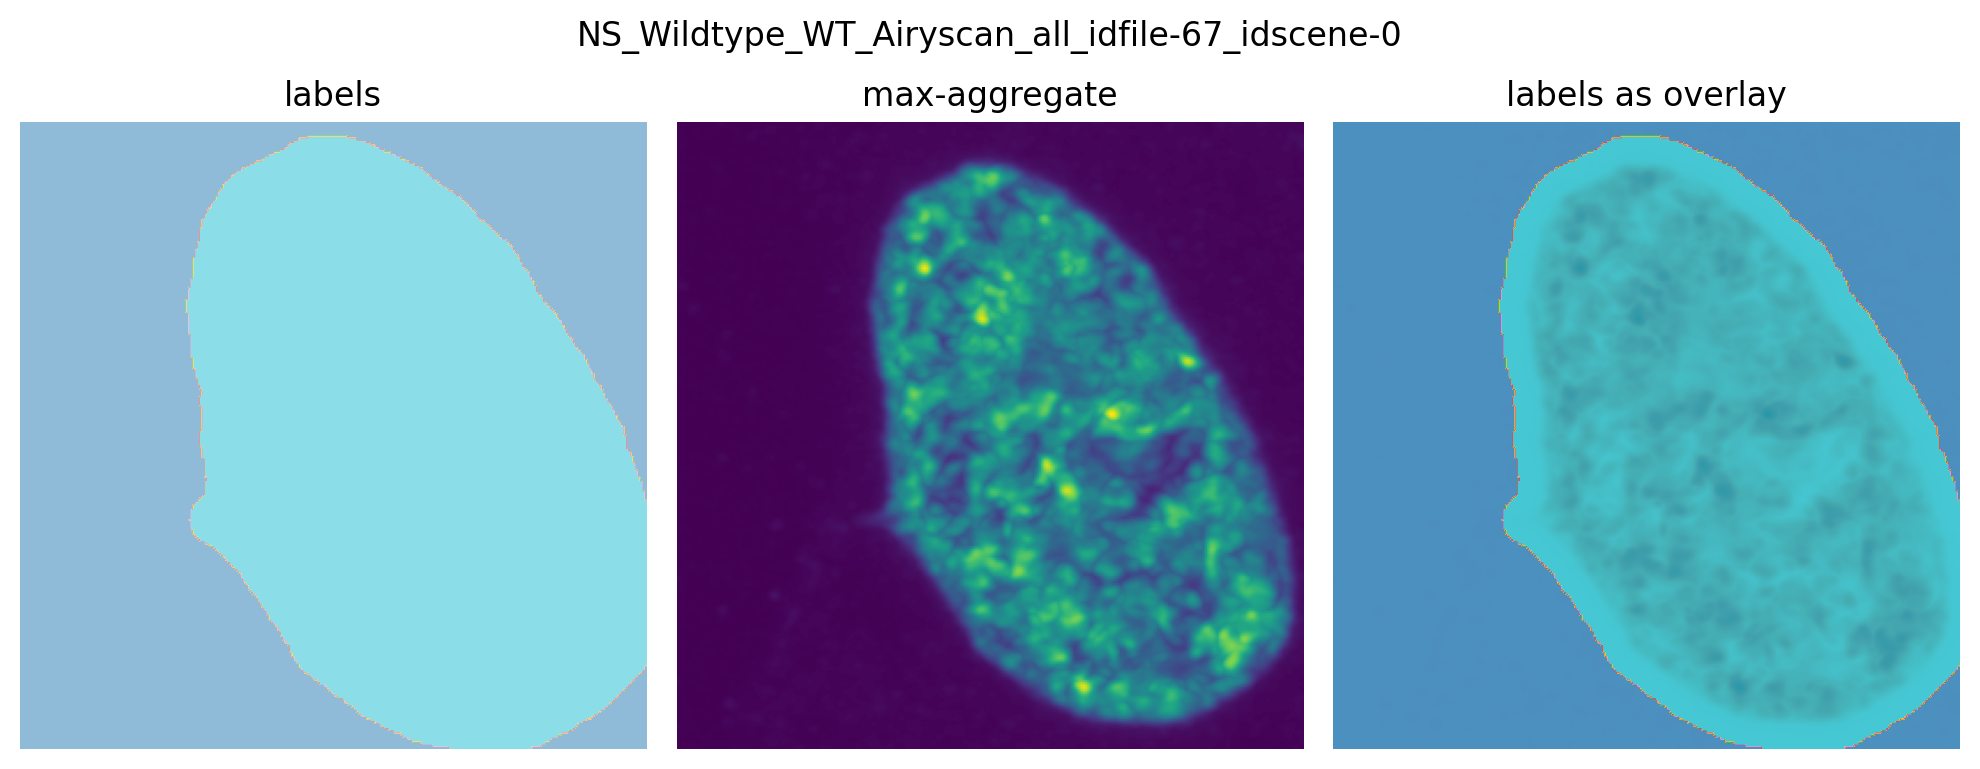

: 

In [18]:
pipe_plot_marked_regions(df_select, nuclei, expanded_new, root=root)
viewer.close()

10013


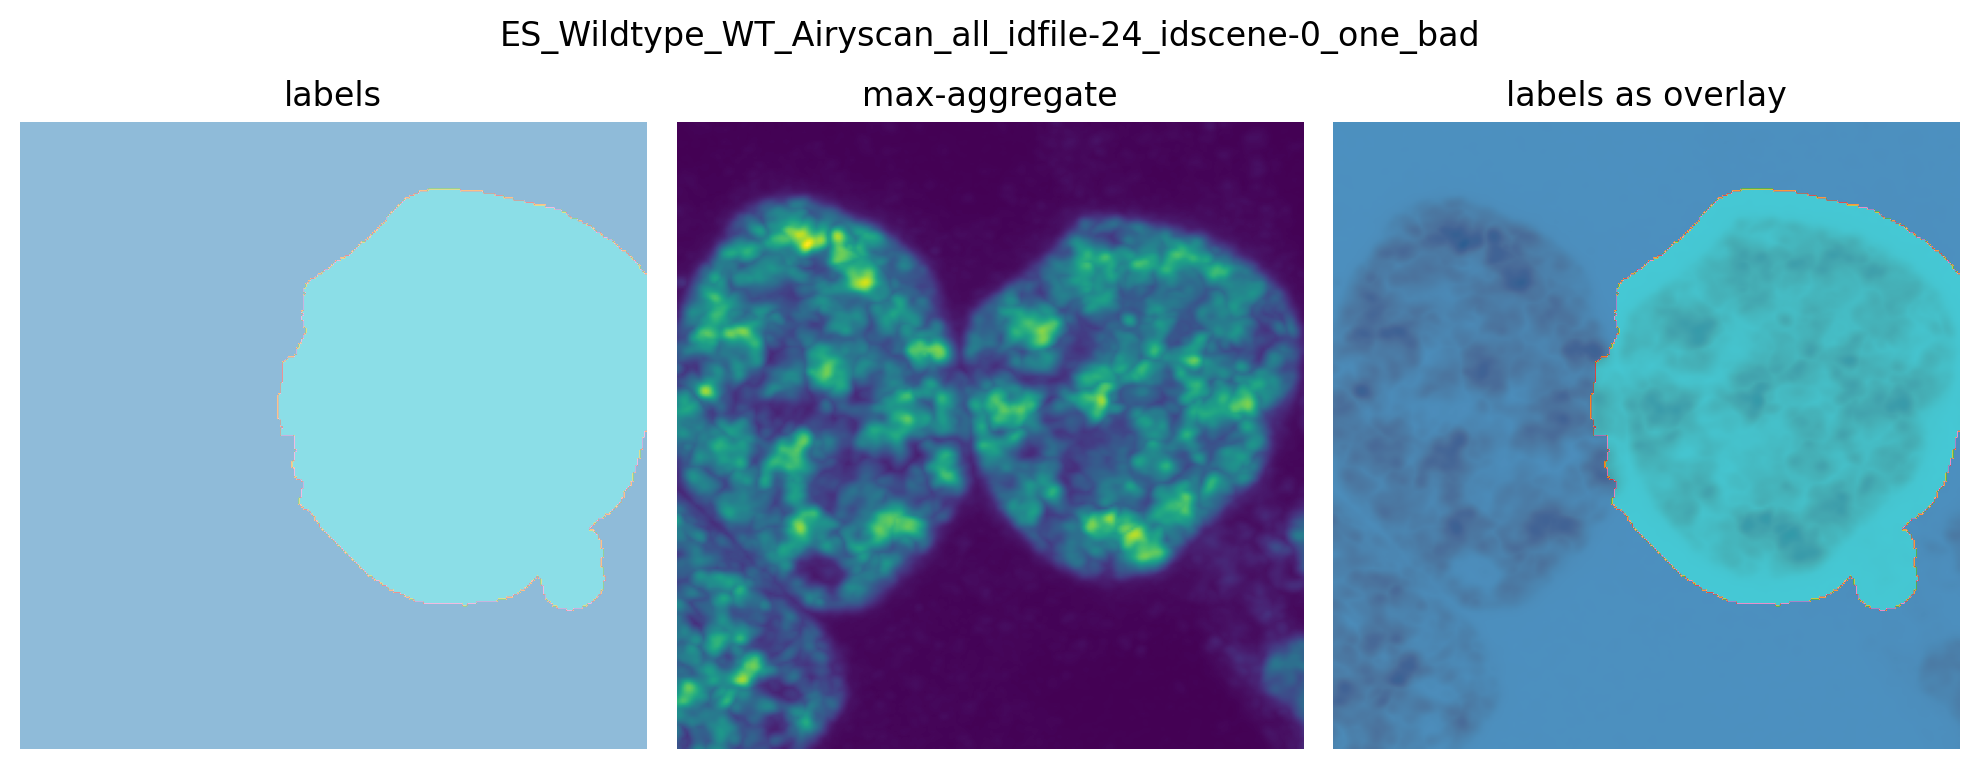

In [13]:
# just one
pipe_plot_marked_regions(df_select, nuclei, expanded_new, root=root, bad_one='one_bad')
viewer.close()

#### try to extract mask from these images

In [271]:
nuclei, info = read_cizlif_file(df_select['filepath'],
                                    df_select['id_scene'],
                                    date=df_select['date'])
images = np.load(Path(path, fn_base +'.npz'))

# prepare the files
image = images['00'].astype(np.float32)
image[image == np.min(nuclei)] = 0

nuclei = nuclei.astype(np.float32)
nuclei[nuclei == np.min(nuclei)] = 0